In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import random
pd.set_option('display.max_columns', 50)

adj_jpm = pd.DataFrame.from_csv('adjJPM.csv')
display(adj_jpm.head())

,Open,High,Low,Close,Volume,Adj Close
1983-12-30,2.602623,2.632198,2.573048,44.000008,3.575624e+06,2.602623
1984-01-03,2.598926,2.617409,2.580440,44.000008,6.517272e+06,2.602623
1984-01-04,2.652532,2.713529,2.617410,45.874979,4.945011e+06,2.713529
1984-01-05,2.768984,2.802256,2.735712,47.375008,5.817363e+06,2.802256
1984-01-06,2.772681,2.802256,2.743106,46.875014,3.286531e+06,2.772681


In [58]:
from numpy.linalg import inv

class Kalman(object):
    def __init__(self, init_price, measurement_var, noise=1):
        self.dt = 1 # time scale
        self.noise = noise
        
        self.x = np.array([init_price, 0]) # State vector: [price, price_rate] (2x1)
        self.P = np.array([[1, 0], [0, 1]]) # Uncertainty covariance matrix (2x2)
        
        self.F = np.array([[1, self.dt], [0, 1]]) # Prediction matrix (2x2)
        self.Q = np.array([[noise, 0], [0, noise]]) # Unpredictable external factor noice covariance matrix (2x2)
        
        self.H = np.array([1, 0]) # Measurement mapping function (1x2)
        self.R_h = measurement_var[0] # Sensor noice covariance (scalar)
        self.R_l = measurement_var[1] # Sensor noice covariance (scalar)
        self.R_c = measurement_var[2] # Sensor noice covariance (scalar)
        self.R_o = measurement_var[2] # Sensor noice covariance (scalar)
        
        
    def predict(self):
        self.x = np.matmul(self.F, self.x) # Predict today's adj close
        self.P = np.matmul(np.matmul(self.F, self.P), self.F.T) + self.Q
    
    def update(self, measurement, sensor_type):
        y = measurement - np.matmul(self.H, self.x) # Calculate loss
        
        if sensor_type == 'high':
            S = np.matmul(np.matmul(self.H, self.P), self.H.T) + self.R_h
        elif sensor_type == 'low':
            S = np.matmul(np.matmul(self.H, self.P), self.H.T) + self.R_l
        elif sensor_type == 'close':
            S = np.matmul(np.matmul(self.H, self.P), self.H.T) + self.R_c
        else:
            S = np.matmul(np.matmul(self.H, self.P), self.H.T) + self.R_o
            
        K = np.matmul(self.P, self.H.T) * (1/S) # Calculate Kalman gain (2x1)
        
        # Update x and P
        self.x = self.x + K * y
        self.P = np.matmul(np.eye(2, 2) - np.matmul(K, self.H), self.P)

### Analyze and find R

In [49]:
adj_jpm['Adj Close shift'] = adj_jpm['Adj Close'].shift(-1)
adj_jpm['Open shift'] = adj_jpm['Open'].shift(-1)

In [50]:
adj_jpm.head()

,Open,High,Low,Close,Volume,Adj Close,Adj Close shift,Open shift
1983-12-30,2.602623,2.632198,2.573048,44.000008,3.575624e+06,2.602623,2.602623,2.598926
1984-01-03,2.598926,2.617409,2.580440,44.000008,6.517272e+06,2.602623,2.713529,2.652532
1984-01-04,2.652532,2.713529,2.617410,45.874979,4.945011e+06,2.713529,2.802256,2.768984
1984-01-05,2.768984,2.802256,2.735712,47.375008,5.817363e+06,2.802256,2.772681,2.772681
1984-01-06,2.772681,2.802256,2.743106,46.875014,3.286531e+06,2.772681,2.780073,2.780073


In [51]:
adj_jpm['high_diff'] = adj_jpm['High'] - adj_jpm['Adj Close shift']
adj_jpm['low_diff'] = adj_jpm['Low'] - adj_jpm['Adj Close shift']
adj_jpm['close_diff'] = adj_jpm['Adj Close'] - adj_jpm['Adj Close shift']
adj_jpm['open_diff'] = adj_jpm['Open shift'] - adj_jpm['Adj Close shift']

In [52]:
adj_jpm.head()

,Open,High,Low,Close,Volume,Adj Close,Adj Close shift,Open shift,high_diff,low_diff,close_diff,open_diff
1983-12-30,2.602623,2.632198,2.573048,44.000008,3.575624e+06,2.602623,2.602623,2.598926,0.029575,-0.029575,0.000000,-0.003697
1984-01-03,2.598926,2.617409,2.580440,44.000008,6.517272e+06,2.602623,2.713529,2.652532,-0.096120,-0.133089,-0.110906,-0.060997
1984-01-04,2.652532,2.713529,2.617410,45.874979,4.945011e+06,2.713529,2.802256,2.768984,-0.088727,-0.184846,-0.088727,-0.033272
1984-01-05,2.768984,2.802256,2.735712,47.375008,5.817363e+06,2.802256,2.772681,2.772681,0.029575,-0.036969,0.029575,0.000000
1984-01-06,2.772681,2.802256,2.743106,46.875014,3.286531e+06,2.772681,2.780073,2.780073,0.022183,-0.036967,-0.007392,0.000000


In [53]:
adj_jpm.dropna(inplace=True)

In [54]:
adj_jpm.shape

(8255, 12)

In [55]:
high_var = adj_jpm['high_diff'].std()**2
low_var = adj_jpm['low_diff'].std()**2
close_var = adj_jpm['close_diff'].std()**2
open_var = adj_jpm['open_diff'].std()**2

In [56]:
print(high_var)
print(low_var)
print(close_var)
print(open_var)

0.476790628832
0.505958428313
0.353023238507
0.249999690789


In [60]:
init_price = adj_jpm.ix[0, 0]

kalman = Kalman(init_price, [high_var, low_var, close_var, open_var])

In [61]:
prediction = []

for i, r in adj_jpm.iterrows():
    # Predict
    kalman.predict()
    
    # Measurement Update
    # Update using High
    kalman.update(measurement=r['High'], sensor_type='high')
    
    # Update using High
    kalman.update(measurement=r['Low'], sensor_type='high')
    
    # Update using High
    kalman.update(measurement=r['Adj Close'], sensor_type='close')
    
    # Update using High
    kalman.update(measurement=r['Open shift'], sensor_type='open')
    
    prediction.append(kalman.x[0])

In [63]:
adj_jpm['kalman_pred'] = prediction

In [64]:
adj_jpm.head()

,Open,High,Low,Close,Volume,Adj Close,Adj Close shift,Open shift,high_diff,low_diff,close_diff,open_diff,kalman_pred
1983-12-30,2.602623,2.632198,2.573048,44.000008,3.575624e+06,2.602623,2.602623,2.598926,0.029575,-0.029575,0.000000,-0.003697,2.598906
1984-01-03,2.598926,2.617409,2.580440,44.000008,6.517272e+06,2.602623,2.713529,2.652532,-0.096120,-0.133089,-0.110906,-0.060997,2.652344
1984-01-04,2.652532,2.713529,2.617410,45.874979,4.945011e+06,2.713529,2.802256,2.768984,-0.088727,-0.184846,-0.088727,-0.033272,2.768833
1984-01-05,2.768984,2.802256,2.735712,47.375008,5.817363e+06,2.802256,2.772681,2.772681,0.029575,-0.036969,0.029575,0.000000,2.772745
1984-01-06,2.772681,2.802256,2.743106,46.875014,3.286531e+06,2.772681,2.780073,2.780073,0.022183,-0.036967,-0.007392,0.000000,2.780060


In [65]:
from sklearn.metrics import r2_score

y_true = adj_jpm['Adj Close shift']

naive = r2_score(y_true, adj_jpm['Adj Close'])
kalman_pred = r2_score(y_true, prediction)

In [66]:
print(naive)
print(kalman_pred)

0.99880527908
0.999154074353


In [75]:
naive_df = pd.DataFrame(adj_jpm['Adj Close'])
naive_df['Adj_Close'] = adj_jpm['Adj Close shift']

In [77]:
naive_df.columns = ['Naive', 'Adj_Close']

In [78]:
naive_df.head()

,Naive,Adj_Close
1983-12-30,2.602623,2.602623
1984-01-03,2.602623,2.713529
1984-01-04,2.713529,2.802256
1984-01-05,2.802256,2.772681
1984-01-06,2.772681,2.780073


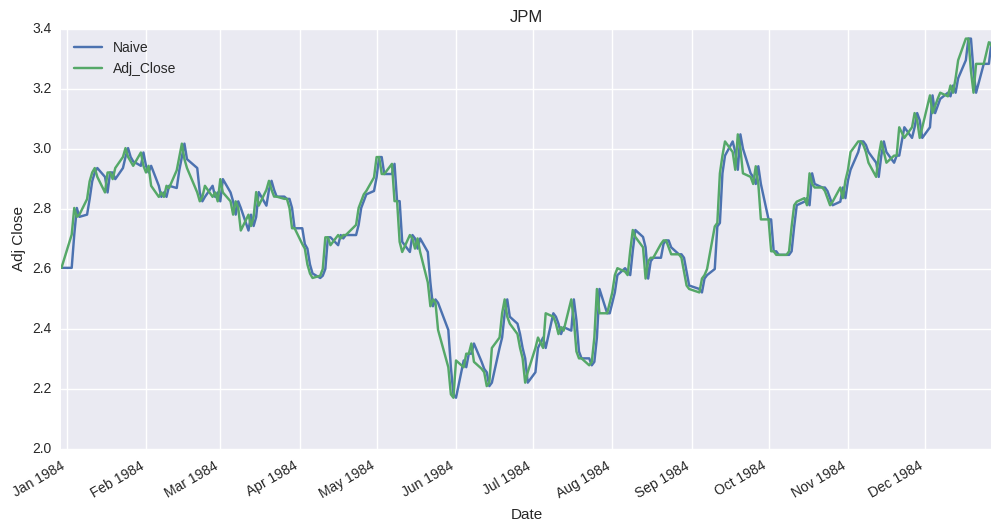

In [81]:
ax = naive_df.ix[0:252, :].plot(figsize=(12, 6), title='JPM')
ax.set_xlabel("Date")
ax.set_ylabel("Adj Close")
plt.show()

In [82]:
kalman_df = pd.DataFrame(adj_jpm['kalman_pred'])
kalman_df['Adj_Close'] = adj_jpm['Adj Close shift']
kalman_df.columns = ['Kalman', 'Adj_Close']

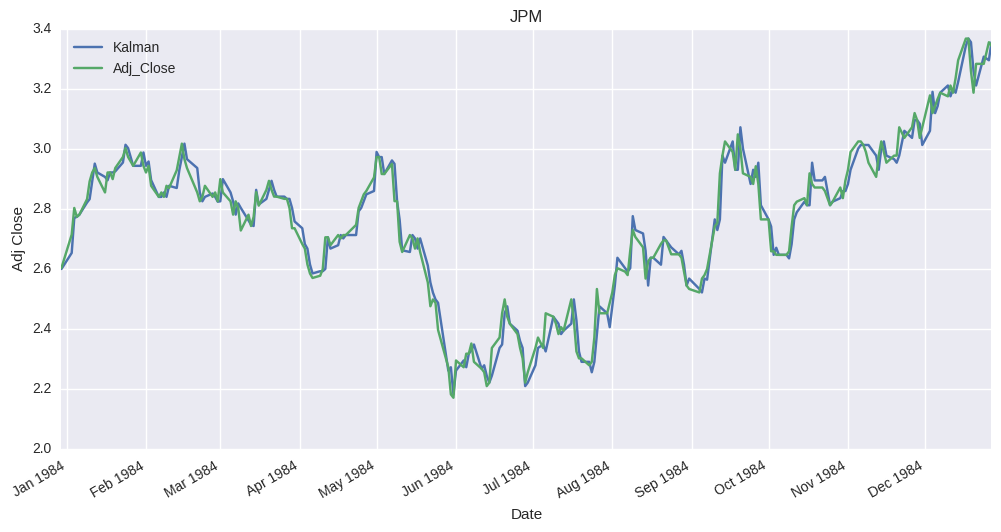

In [83]:
ax = kalman_df.ix[0:252, :].plot(figsize=(12, 6), title='JPM')
ax.set_xlabel("Date")
ax.set_ylabel("Adj Close")
plt.show()